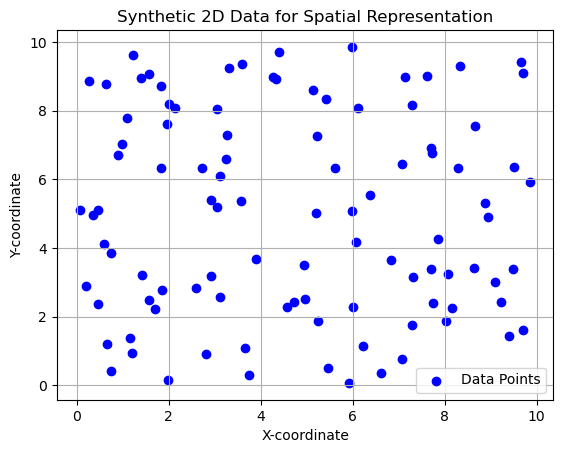

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility (optional)
np.random.seed(42)

# Number of data points to generate
num_points = 100

# Generate synthetic 2D data
x = np.random.uniform(0, 10, num_points)  # x-coordinates (randomly chosen between 0 and 10)
y = np.random.uniform(0, 10, num_points)  # y-coordinates (randomly chosen between 0 and 10)

# Plot the data points
plt.scatter(x, y, c='b', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Synthetic 2D Data for Spatial Representation')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import Rbf
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

# Synthetic 2D data generation with altitude values
np.random.seed(41)
num_points = 30
x = np.random.uniform(0, 3, num_points)
y = np.random.uniform(0, 3, num_points)
altitude = np.random.uniform(0, 100, num_points)  # Altitude values between 0 and 100

# Define the grid for interpolation
grid_x, grid_y = np.meshgrid(np.linspace(0, 3, num_points), np.linspace(0, 3, num_points))

# Polygonal Interpolation (Nearest Neighbor)
tri = Delaunay(np.column_stack((x, y)))
interpolator = LinearNDInterpolator(tri, altitude)
interpolated_values_polygonal = interpolator(grid_x, grid_y)

# Inverse Distance Weighting (IDW) Interpolation
interpolator_idw = Rbf(x, y, altitude, function='linear')
interpolated_values_idw = interpolator_idw(grid_x, grid_y)

simple_kriging_model = SimpleKriging(x, y, altitude, variogram_model='exponential', verbose=False)
interpolated_values_kriging, _ = simple_kriging_model.execute('grid', grid_x, grid_y)

# Kriging Interpolation
# kriging_model = OrdinaryKriging(x, y, altitude, variogram_model='spherical',
#                                 variogram_parameters={'sill': 10, 'range': 10, 'nugget': 0.01, 'slope': 0.3})
# interpolated_values_kriging, _ = kriging_model.execute('grid', grid_x, grid_y)

# Plotting the results
plt.figure(figsize=(12, 10))

# Original data points with altitude
plt.subplot(2, 2, 1)
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.colorbar(label='Altitude')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Original Data Points with Altitude')
plt.legend()
plt.grid(True)

# Polygonal Interpolation
plt.subplot(2, 2, 2)
plt.imshow(interpolated_values_polygonal, extent=(0, 3, 0, 3), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Polygonal Interpolation')
plt.legend()
plt.grid(True)

# Inverse Distance Weighting (IDW) Interpolation
plt.subplot(2, 2, 3)
plt.imshow(interpolated_values_idw, extent=(0, 3, 0, 3), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Inverse Distance Weighting (IDW) Interpolation')
plt.legend()
plt.grid(True)

# Kriging Interpolation
plt.subplot(2, 2, 4)
plt.imshow(interpolated_values_kriging, extent=(0, 3, 0, 3), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Kriging Interpolation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'pykrige'

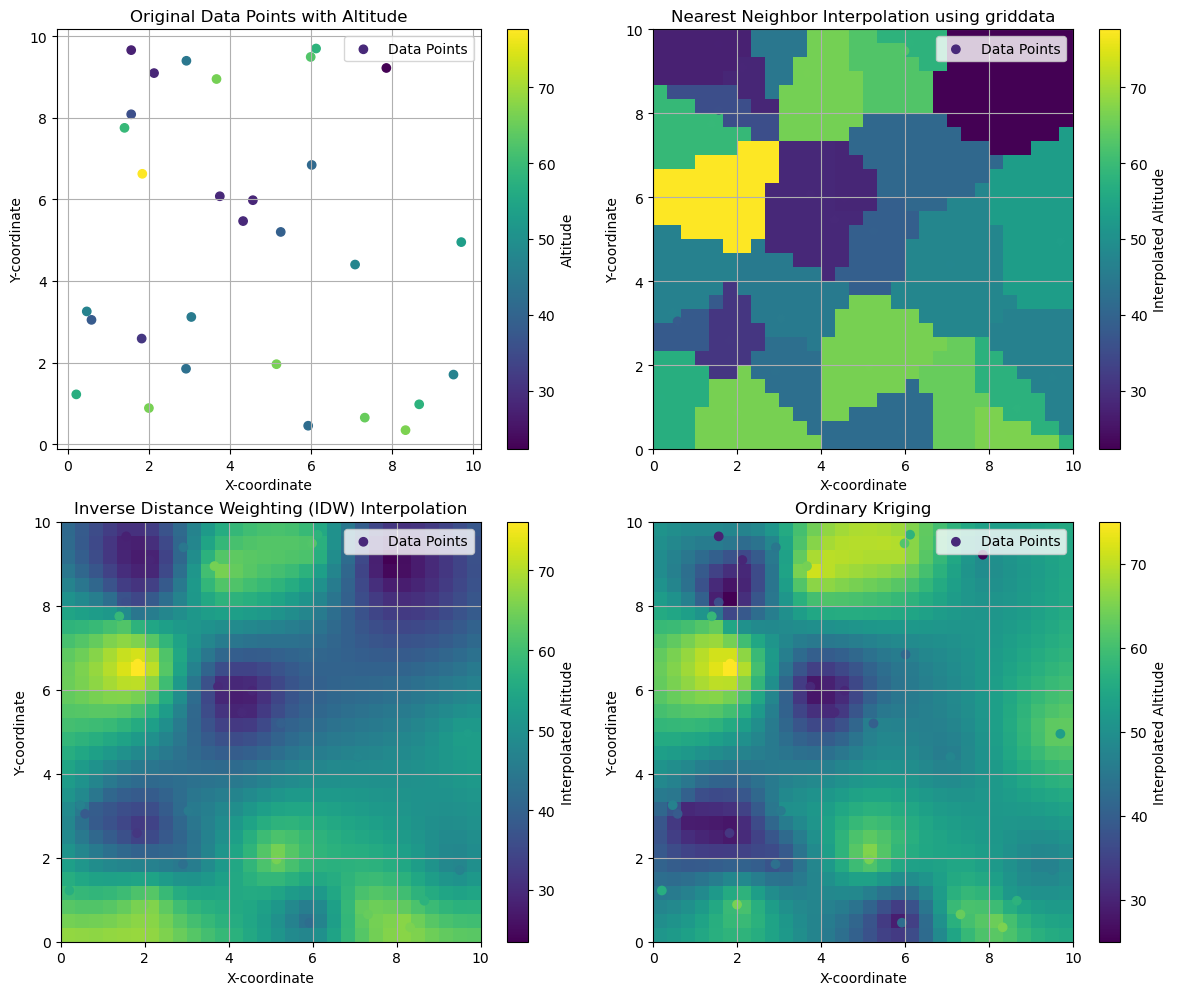

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist

# Function to generate synthetic altitude data with spatial pattern
def generate_synthetic_altitude(x, y):
    return 50 + 25 * np.sin(x) * np.cos(y)

# Function to calculate the variogram
def variogram(h, nugget, sill, range_, model='spherical'):
    if model == 'spherical':
        return nugget + (sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3))
    elif model == 'exponential':
        return nugget + (sill * (1 - np.exp(-3 * h / range_)))
    elif model == 'gaussian':
        return nugget + (sill * (1 - np.exp(-(3 * h / range_)**2)))
    else:
        raise ValueError("Invalid variogram model.")

# Function to perform Ordinary Kriging
def ordinary_kriging(x, y, z, grid_x, grid_y, range_, sill, nugget, model='spherical'):
    def variogram(h, nugget, sill, range_, model):
        if model == 'spherical':
            return nugget + (sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3))
        elif model == 'exponential':
            return nugget + (sill * (1 - np.exp(-3 * h / range_)))
        elif model == 'gaussian':
            return nugget + (sill * (1 - np.exp(-(3 * h / range_)**2)))
        else:
            raise ValueError("Invalid variogram model.")
    
    n = len(x)
    m = len(grid_x)
    distances_obs = cdist(np.array([(x[i], y[i]) for i in range(n)]), np.array([(x[i], y[i]) for i in range(n)]))
    distances_grid = cdist(np.array([(grid_x[i], grid_y[i]) for i in range(m)]), np.array([(x[i], y[i]) for i in range(n)]))
    
    cov_matrix = variogram(distances_obs, nugget, sill, range_, model)
    cov_matrix[np.isnan(cov_matrix)] = 0.0
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    weights = np.dot(distances_grid, inv_cov_matrix.T)
    
    interpolated_values = np.dot(weights, z)
    return interpolated_values



# Synthetic 2D data generation with altitude values
np.random.seed(42)
num_points = 30  # Change the number of points to 30
x = np.random.uniform(0, 10, num_points)
y = np.random.uniform(0, 10, num_points)

# Generate synthetic altitude values with spatial pattern and add some noise
altitude = generate_synthetic_altitude(x, y) + np.random.normal(0, 5, num_points)

# Define the grid for interpolation (30x30 points)
grid_x, grid_y = np.meshgrid(np.linspace(0, 10, 30), np.linspace(0, 10, 30))

# Nearest Neighbor Interpolation using griddata
interpolated_values_nearest = griddata((x, y), altitude, (grid_x, grid_y), method='nearest')

# Inverse Distance Weighting (IDW) Interpolation
from scipy.interpolate import Rbf
interpolator_idw = Rbf(x, y, altitude, function='linear')
interpolated_values_idw = interpolator_idw(grid_x, grid_y)

# Ordinary Kriging
range_ = 1 #1
sill = 0.1 #0.1
nugget = 10 #10
interpolated_values_ordinary_kriging = ordinary_kriging(x, y, altitude, grid_x.ravel(), grid_y.ravel(), range_, sill, nugget)

# Plotting the results
plt.figure(figsize=(12, 10))

# Original data points with altitude
plt.subplot(2, 2, 1)
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.colorbar(label='Altitude')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Original Data Points with Altitude')
plt.legend()
plt.grid(True)

# Nearest Neighbor Interpolation using griddata
plt.subplot(2, 2, 2)
plt.imshow(interpolated_values_nearest, extent=(0, 10, 0, 10), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Nearest Neighbor Interpolation using griddata')
plt.legend()
plt.grid(True)

# Inverse Distance Weighting (IDW) Interpolation
plt.subplot(2, 2, 3)
plt.imshow(interpolated_values_idw, extent=(0, 10, 0, 10), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Inverse Distance Weighting (IDW) Interpolation')
plt.legend()
plt.grid(True)


new_min = 25.0
new_max = 75.0

# Normalize the values to the range [0, 1]
min_value = np.min(interpolated_values_ordinary_kriging)
max_value = np.max(interpolated_values_ordinary_kriging)
normalized_values = (interpolated_values_ordinary_kriging - min_value) / (max_value - min_value)

# Scale the normalized values to the new range [new_min, new_max]
interpolated_values_ordinary_kriging = (normalized_values * (new_max - new_min)) + new_min

# Ordinary Kriging
plt.subplot(2, 2, 4)
plt.imshow(interpolated_values_ordinary_kriging.reshape(30, 30), extent=(0, 10, 0, 10), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Ordinary Kriging')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

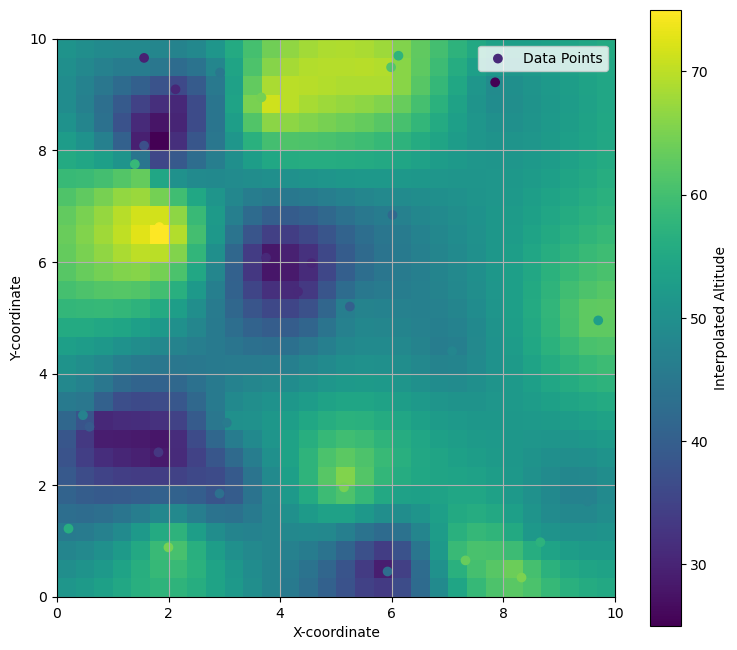

In [36]:
plt.figure(figsize=(9, 8))
plt.imshow(interpolated_values_ordinary_kriging.reshape(30, 30), extent=(0, 10, 0, 10), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Altitude')
plt.scatter(x, y, c=altitude, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)